# Tutorial 4: The truncated and shifted Lennard-Jones potential

## Physics 7810, Spring 2020

## T4.1 - Truncated and shifted Lennard-Jones potential, WCA potential

In the second homework assignment, you wrote a simple molecular dynamics (MD) simulation program for the 3D Lennard-Jones (LJ) system, using the minimum-image convention. In this tutorial, you'll modify your MD simulation code to implement a truncated and shifted LJ potential. Imposing a spherical cutoff can lead to significant speedups in the execution of MD (or MC) code, when used in conjunction with fast neighbor-search methods such as cell lists and/or Verlet neighbor lists.

In the previous tutorial, we investigated the effects of truncation on energy conservation in an MD simulation of a system of interaction particles in a central force potential. To achieve improved energy conservation in MD simulations, it's common to shift the pair potential $u(r_{ij})$ so that it's continuous at the cutoff distance $r_c$:

$$
u^\prime(r_{ij}) = \left\{
\begin{array}{ll}
u(r_{ij}) - u(r_c), & r_{ij} < r_c \\
0, & r_{ij} \geq r_c
\end{array}
\right..
$$

Note that shifting the potential doesn't change the pair forces.

Modify your LJ MD simulation code to implement a truncated and shifted pair potential. Investigate whether shifting the pair potential to be continuous at the cutoff improves energy conservation, by comparing the rms fluctuation in total energy $\langle \delta E^2 \rangle^{1/2} / \langle E \rangle$ in a simulation using the *truncated and shifted* potential $u_{\rm LJ}^\prime(r_{ij})$ with a simulation using the *truncated but unshifted* potential $u_{\rm LJ}(r_{ij})$ for a specific cutoff distance, say $r_c = 2.5 \sigma$. Note that the linear dimension of your simulation box must be at least twice the cutoff distance, $L \geq 2 r_c$.

Recall that

$$
\frac{\langle \delta E^2 \rangle^{1/2}}{\langle E \rangle} = \frac{\langle (E - \langle E \rangle)^2 \rangle^{1/2}}{\langle E \rangle},
$$

where

$$
\langle \delta E^2 \rangle = \langle (E - \langle E \rangle)^2 \rangle = \langle E^2 - 2 E \langle E \rangle + \langle E \rangle^2 \rangle
= \langle E^2 \rangle - \langle E \rangle^2.
$$

A particularly useful pair potential is obtained by truncating and shifting the LJ pair potential at a cutoff distance corresponding to its minimum, to obtain the so-called *Weeks-Chandler-Andersen* (WCA) potential. This potential is short-ranged and purely repulsive, and both the potential and the force are continuous at the cutoff.

Determine the pair separation $r_{\rm min}$ corresponding to the minimum in the LJ potential, and plot the WCA potential $u_{\rm WCA}(r)$ as a function of $r$. Implement the WCA potential in your MD code, and run a simulation using the WCA potential to test for energy conservation.

### Solution

#### Problem1: Comparison between MD simulation with or without shifting the potential energy

First, we load the Python library for MD simulations, `Molecular_Simulations.py` and the parameters for the MD simulation.

In [1]:
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

Then, we read in the parameters specified in `Tutorial_04.yml`.

In [9]:
mdp = Initialization('Tutorial_04.yml')
MD = MolecularDynamics(mdp)

**Case 1**: Truncated but unshifted energy $u_{LJ}(r_{ij})$

RMSF:  -0.003930519133967207


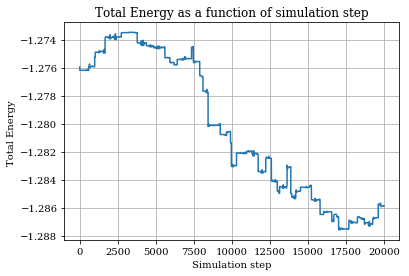

In [11]:
MD.shift_energy = 'no'
MD.verlet_integration(MD.velocities, MD.coords)
TA = TrajAnalysis(MD, 'Tutorial_04_traj.yml')
TA.plot_2d(TA.E_total, 'Total Energy')
RMSF = TA.calculate_RMSF(TA.E_total)
print('RMSF: ', RMSF)

**Case 2**: Truncated and shifted energy $u_{\rm LJ}^\prime(r_{ij})$

RMSF:  -5.145756199474428e-08


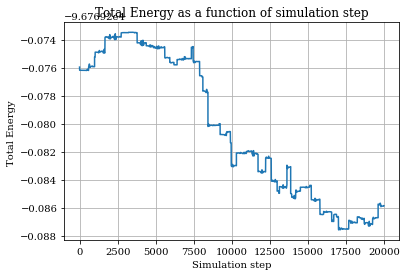

In [12]:
MD.shift_energy = 'yes'
MD.verlet_integration(MD.velocities, MD.coords)
TA = TrajAnalysis(MD, 'Tutorial_04_traj.yml')
TA.plot_2d(TA.E_total, 'Total Energy')
RMSF = TA.calculate_RMSF(TA.E_total)
print('RMSF: ', RMSF)

As shown above, without shifting the total energy, the RMSF value is about -0.000167, which is acceptable but also can be improved further. On the other hand, after shifting the total energy, the RMSF value is 0, which exhibit a even better conservation of the total energy.

#### Problem 2: Determintion of $r_{min}$ of Lennard-Jones potential

Recall that Lennard-Jones potential can be expressed as:
$$V_{LJ} = 4 \epsilon \left [ \left (\frac{\sigma}{r} \right)^{12} - \left (\frac{\sigma}{r} \right)^{6} \right ]$$

To determine $r_{min}$, the distance at which the potential reaches its minimum, we have to solve $\frac{dV_{LJ}}{dr} = 0$ as follows:
$$\frac{dV_{LJ}}{dr} = 4 \epsilon(12\sigma^{12}r^{-13}-6\sigma^{6}r^{-7}) =0 \Rightarrow r^{-7}(2 \sigma^{6} r^{-6} -1)=0 \Rightarrow r= r_{min} = 2^{1/6} \sigma$$

To plot $u_{WCA}(r)$ as a function of $r$, we can just use `LJ_potential` in the class `ComputePotentials` as follows:

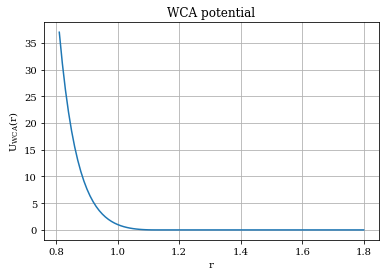

In [80]:
CP = ComputePotentials('Tutorial_04.yml')
coord_i = np.zeros([1, 3])
coord_j = np.zeros([100, 3])
r_ij, u_wca = [], []

for i in range(len(coord_j)):
    coord_j[i][2] = 0.01 * (i + 1) + 0.8
    r_ij.append(norm(coord_i - coord_j[i]))
    u_wca.append(CP.LJ_potential(coord_i, coord_j[i]))
    # so r_ij ranges from 0.8 to 1.8
    
plt.figure()
plt.plot(r_ij, u_wca)
plt.xlabel('$ r $')
plt.ylabel('$ U_{WCA}(r) $')
plt.title('WCA potential')
plt.grid()

With $\sigma$ being 1, $r_{min} = 2^{1/6} \approx 1.122$, which is used as the cutoff distance in WCA potential. As a result, any pair distance larger than $r_c$ corresponds to a 0 potential. Also, because we shifted the potential at $r_{min}$ from the original negative value to 0, the potential function is continuous and repulsive (for positive values) everywhere.

#### Problem 3: Implementation of WCA potential

To implement the WCA potential, we just have to add the following lines in the `__init__` function in the class `Initialization`:
```python
if self.potential == 'WCA':
    self.energy_truncation == 'yes'
    self.shift_energy == 'yes'
    self.r_c = self.r_min
```

Then, with parameters specified in `Tutorial_04.yml`, we can perform an MD simulation as below:

RMSF:  1.230641895355348e-06


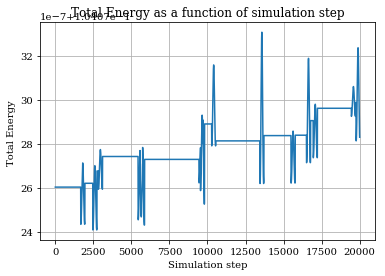

In [2]:
mdp = Initialization('Tutorial_04.yml')
MD = MolecularDynamics(mdp)
MD.verlet_integration(MD.velocities, MD.coords)
TA = TrajAnalysis(MD, 'Tutorial_04_traj.yml')
TA.plot_2d(TA.E_total, 'Total Energy')
RMSF = TA.calculate_RMSF(TA.E_total)
print('RMSF: ', RMSF)

As expected, since the potential is shifted in WCA potential, the total energy exhibit a pretty small fluctuation as the one in previous case of truncated and shifted energy. Quantitatively, the RMSF value is only about $1.23 \times 10^{-6}$. Therefore, WCA potential is reasonable to use to decrease the computational cost while no accuracy will be sacrificed.